# Plan for this notebook
1. Review a GAN to genearate faces. In the competition, you will also need to generate images, BTW.

Image GANs are computationally heavy and tricky to design, so we don't ask you to create one in the scope of a seminar. But you are of couse welcome to try!

Based on based on based on https://github.com/Lasagne/Recipes/pull/94,  https://github.com/yandexdataschool/Practical_DL/blob/spring2019/week08_adversarial/adversarial_pytorch.ipynb with traces of https://towardsdatascience.com/implementing-a-generative-adversarial-network-gan-dcgan-to-draw-human-faces-8291616904a


# Technicalities & getting the data

Don't forget to change the runtime to include a GPU (Runtime -> Change runtime type)

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.datasets import lfw

Also, let's mount the Google Drive to save the the models. As you surely remember, the filesystem in a colab runtime is not pesistent.

In [0]:
# import os
# from google.colab import drive
# GDRIVE_PATH = '/content/gdrive'
# THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "My Drive", "GAN_exercises")
# MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "models")
# drive.mount(GDRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
# os.makedirs(MODELS_HOME, exist_ok=True)

Get the data:

In [4]:
# You can also persist the dataset, but in my experience getting it from the Google Drive is slower than downloading it
# LFW_DATA_HOME = os.path.join(THIS_EXERCISE_PATH, "lfw_dataset")
LFW_DATA_HOME = None
lfw_dataset = lfw.fetch_lfw_people(color=True, slice_=(slice(80, 170, None), slice(80, 170, None)),
                                   data_home=LFW_DATA_HOME, resize=0.4)

In [5]:
# Just a check to make sure the dataset is compartiable with the processing that follows
assert lfw_dataset['images'].shape == (13233, 36, 36, 3)

So far our data has the following shape: (n_images, height, width, n_channels). PyTorch convolutional layers want the channels dimension to be the second one (axis=1), so let's transpose (and normalize) the data:

In [6]:
data = lfw_dataset['images'].transpose(0, 3, 1, 2).astype(np.float32) / 255.

Let's see what we've get. Here's a function to plot a (optionally random) subset of images:

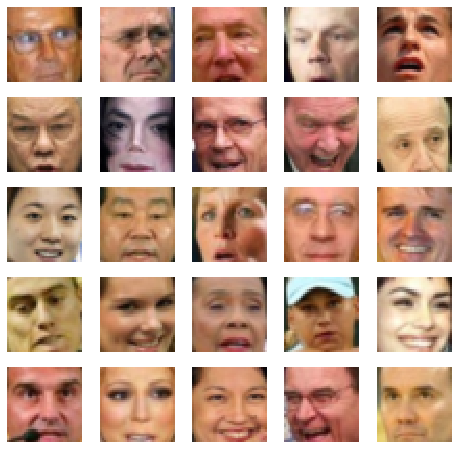

In [7]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx].transpose(1, 2, 0),
                interpolation="none")
      ax.set_axis_off()
  return figure

plot_images(data);

# Building the GAN
Finally, let's import torch and define the Reshape layer (same as in the introduction to PyTorch):

In [8]:
import torch
from torch import nn
from torch.nn.functional import logsigmoid

class Reshape(torch.nn.Module):
  """
  Reshapes a tensor starting from the 1st dimension (not 0th),
  i. e. without influencing the batch dimension.
  """
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(x.shape[0], *self.shape)
  
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

### Generator & Discriminator

In [11]:
import os
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator.pt')

NameError: name 'MODELS_HOME' is not defined

In [12]:
CODE_SIZE = 128
DROPOUT_RATE = 0.1

# try:
#   generator = torch.load(GENERATOR_FILE)
#   discriminator = torch.load(DISCRIMINATOR_FILE)
if True:
  generator = torch.nn.Sequential(
      torch.nn.Linear(CODE_SIZE, 256 * 4 * 4),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      Reshape(256, 4, 4), # 4x4
      torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Upsample(scale_factor=2), # 8x8
      
      torch.nn.Conv2d(128, 64, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.ConvTranspose2d(64, 64, kernel_size=3), # 10x10
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Upsample(scale_factor=2), # 20x20
      
      torch.nn.Conv2d(64, 32, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Upsample(scale_factor=2), # 40x40
      torch.nn.Conv2d(32, 16, kernel_size=3, padding=0), # 38x38
      torch.nn.ELU(),
      
      torch.nn.Dropout(p=DROPOUT_RATE),
      torch.nn.Conv2d(16, 8, kernel_size=3, padding=0), # 36x36
      torch.nn.ELU(),
      
      torch.nn.Dropout(p=DROPOUT_RATE),
      torch.nn.ConvTranspose2d(8, 3, kernel_size=1), # 36x36
  ).cuda()

  discriminator = torch.nn.Sequential(
      torch.nn.Conv2d(3, 8, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.MaxPool2d(2), # 18x18
      
      torch.nn.Conv2d(8, 32, kernel_size=3, padding=1),
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.MaxPool2d(2), # 9x9
      
      torch.nn.Conv2d(32, 64, kernel_size=3), # 7x7
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Conv2d(64, 256, kernel_size=3), # 5x5
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      torch.nn.Conv2d(256, 512, kernel_size=3), # 3x3
      torch.nn.ELU(),
      torch.nn.Dropout(p=DROPOUT_RATE),
      
      Reshape(512 * 9),
      torch.nn.Linear(512 * 9, 1)
  ).cuda()


In [13]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, device="cuda")
  return generator(noise)

In [14]:
# A small check that the generator output has the right size
test_generated_data = sample_fake(1)
assert tuple(test_generated_data.shape[1:]) == data.shape[1:]

In [15]:
# As advertised, a discriminator outputs a single number per image
assert discriminator(test_generated_data).shape == (1, 1)

Check that generator and discriminator complexity is roughly the same:

In [16]:
def get_n_params(model):
  return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(generator))
print('discriminator params:', get_n_params(discriminator))

generator params: 958419
discriminator params: 1353537


Then, we need a function to sample real and fake images:

In [17]:
def sample_images(batch_size):
  ids = np.random.choice(len(data), size=batch_size)
  return torch.tensor(data[ids], device="cuda")

Let's have a look what we can generate before any training:

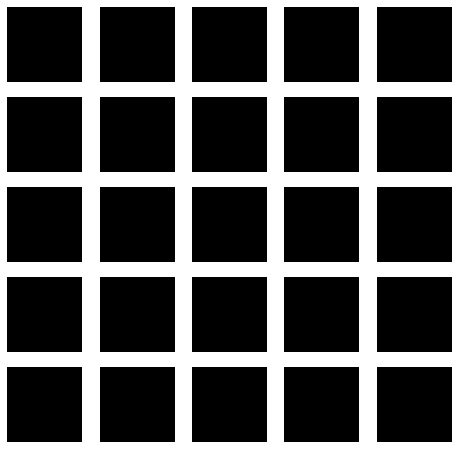

In [18]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plot_images(imgs.clip(0, 1));

A perfect example of [grid illusion](https://en.wikipedia.org/wiki/Grid_illusion), isn't it?

Unsurprisingly, the core loss math is the same as we had in the 1D GAN. And we add some noise. Question to you: what for?

In [19]:
noise_power = 0.3
gradient_penalty = 0.0001

def generator_loss(fake):
  return -logsigmoid(discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()
  
  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

Let's do some more set-up and run the learning process:

In [20]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.999)

In [24]:
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOGDIR = "./logs"
MODEL_NAME = "Faces_GAN_v20"
summary_writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOGDIR, MODEL_NAME))

In [25]:
VALIDATION_INTERVAL = 50
SAVE_INTERVAL = 500
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
BATCH_SIZE=100

In [26]:
from IPython.display import clear_output
for i in range(1000000):
  # Set our models to training mode:
  generator.train()
  discriminator.train()
  gen_scheduler.step()
  disc_scheduler.step()
  
  # Several discriminator updates per step:
  for j in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
    # Sampling reals and fakes
    real = sample_images(BATCH_SIZE)
    fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()

  # Pass the discriminator loss to Tensorboard for plotting 
  summary_writer.add_scalar("discriminator loss", discriminator_loss_this_iter,
                             global_step=i)

  # Now it's generator's time to learn:
  generator_loss_this_iter = generator_loss(sample_fake(BATCH_SIZE))
  summary_writer.add_scalar("generator loss", generator_loss_this_iter,
                            global_step=i)
  optimizer_generator.zero_grad()
  generator_loss_this_iter.backward()
  optimizer_generator.step()

  if i % SAVE_INTERVAL == 0:
    torch.save(generator, GENERATOR_FILE)
    torch.save(discriminator, DISCRIMINATOR_FILE)
    
  if i % VALIDATION_INTERVAL == 0:
    clear_output(wait=True)
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plot_images(imgs.clip(0, 1));
    plt.show();

NameError: name 'GENERATOR_FILE' is not defined

# Task 2 (Bonus, difficulty: open-ended, from 10 minute to copy-paste to a month of work and a paper at ML conference)
Make a better GAN. GANs for different image domains are a very well explored subject. See, for example, [this repository](https://github.com/shayneobrien/generative-models) with documented GAN implementations in torch.